In [0]:
!pip install PyDrive
import os
import json
import datetime
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1cZ4NMEAMD0Kd64wnv9epbnofDipFrNRd'})
download.GetContentFile('ECE219_tweet_data.zip')

In [0]:
!unzip ECE219_tweet_data.zip

Archive:  ECE219_tweet_data.zip
  inflating: tweets_#nfl.txt         
  inflating: tweets_#superbowl.txt   
  inflating: tweets_#sb49.txt        
  inflating: tweets_#patriots.txt    
  inflating: tweets_#gohawks.txt     
  inflating: tweets_#gopatriots.txt  


## Q1

In [0]:
path = "./"

files = ["tweets_#gohawks.txt", "tweets_#gopatriots.txt", "tweets_#nfl.txt", "tweets_#patriots.txt", "tweets_#sb49.txt", "tweets_#superbowl.txt"]
topics = ["gohawks", "gopatriots", "nfl", "patriots", "sb49", "superbowl"]

for i, fl in enumerate(files):
    print("files[" + str(i) + "] => " + fl)

files[0] => tweets_#gohawks.txt
files[1] => tweets_#gopatriots.txt
files[2] => tweets_#nfl.txt
files[3] => tweets_#patriots.txt
files[4] => tweets_#sb49.txt
files[5] => tweets_#superbowl.txt


In [0]:
def load_file(file):
    """
    Load the time(in human readable form), follows, and retweets
    """
    result = []
    pst_tz = pytz.timezone('America/Los_Angeles')
    for line in open(path + file, 'r') :
        a = json.loads(line)
        cita = a['citation_date']
        citetime = datetime.datetime.fromtimestamp(cita,pst_tz)
        foll = a['author']['followers']
        retweet = a['metrics']['citations']['total']
        result.append({'time': citetime, 'followers': foll, 'retweets': retweet})
    return result

In [0]:
def get_statistic(data_list):
    """
    Count average number of tweets per hour, the number of followers per tweet, 
    number of retweets per tweet, and hour-tweets history.
    The starting time is set to be Jan.14th 0:00
    """
    retweet = 0
    followers = 0
    tweets = len(data_list)
    hourlist = []
    for p in data_list:
        retweet += int(p['retweets'])
        followers += int(p['followers'])
        hourlist.append(((p["time"].month-1)*31+p["time"].day-14)*24+p["time"].hour)
    return [float(tweets) / max(hourlist), float(followers) / tweets , float(retweet) / tweets], hourlist

In [0]:
def plot_hist(time_list, title = ""):
    n, bins, patches = plt.hist(time_list, 50, alpha=0.5)
    plt.hist(time_list, bins, alpha=0.5, color="blue")
    plt.xlabel("hour(h)")
    plt.ylabel("number of tweets in hour")
    plt.title(title)
    plt.show()

In [0]:
for i,file_i in enumerate(files):
    topic = load_file(file_i)
    stat, hourlist = get_statistic(topic)
    print("Average number of tweets per hour, Average number of followers of users posting the tweets per tweet, and Average number of retweets per tweet for hashtag "+topics[i]+": ", stat)

Average number of tweets per hour, Average number of followers of users posting the tweets per tweet, and Average number of retweets per tweet for hashtag gohawks:  [292.598615916955, 2217.9237355281984, 2.0132093991319877]
Average number of tweets per hour, Average number of followers of users posting the tweets per tweet, and Average number of retweets per tweet for hashtag gopatriots:  [40.888695652173915, 1427.2526051635405, 1.4081919101697078]
Average number of tweets per hour, Average number of followers of users posting the tweets per tweet, and Average number of retweets per tweet for hashtag nfl:  [397.64846416382255, 4662.37544523693, 1.5344602655543254]
Average number of tweets per hour, Average number of followers of users posting the tweets per tweet, and Average number of retweets per tweet for hashtag patriots:  [751.9129692832764, 3280.4635616550277, 1.7852871288476946]
Average number of tweets per hour, Average number of followers of users posting the tweets per tweet,

## Q2

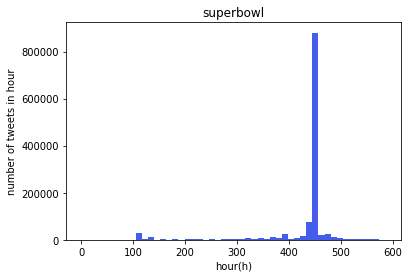

In [0]:
topic = load_file("tweets_#superbowl.txt")
stat, hourlist = get_statistic(topic)
plot_hist(hourlist,"superbowl")

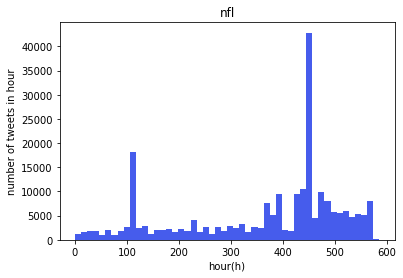

In [0]:
topic = load_file("tweets_#nfl.txt")
stat, hourlist = get_statistic(topic)
plot_hist(hourlist,"nfl")

## Q3

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from statistics import mean
import statsmodels.api as sm

In [0]:
def parse_dataset(file):
    # extract raw features
    pst_tz = pytz.timezone('America/Los_Angeles')
    data_raw = []
    for line in open(path + file, 'r') :
        row_tmp = []
        a = json.loads(line)
        time = a['citation_date']
        retweet = a['metrics']['citations']['total']
        foll = a['author']['followers']        
        row_tmp.append(time)
        row_tmp.append(retweet)
        row_tmp.append(foll)        
        data_raw.append(row_tmp)
    
    # sort according to time
    pddata_raw = pd.DataFrame(data_raw,columns=['time','retweets','followers'])
    pddata_raw = pddata_raw.sort_values(by = 'time')
    pddata_raw = pddata_raw.reset_index(drop=True)
    pddata_raw['tweets'] = 1    
#     print(pddata_raw)

    # reset time to hour index
    hour_accu = []
    hour_day = []
    for index, row in pddata_raw.iterrows():  
        p = datetime.datetime.fromtimestamp(row["time"], pst_tz)  
        hour_accu.append(((p.month-1)*31+p.day-14)*24+p.hour)
        hour_day.append(p.hour)    
    pddata_raw["time"] = hour_accu
    pddata_raw["hour of day"] = hour_day
    
    # create a new dataframe with desired form
    df = pd.DataFrame([],columns=['hour index','tweets','retweets','followers sum','followers max','hour of day'])
    df['hour index'] = range(pddata_raw.iloc[len(pddata_raw.index)-1,0]+1)
    df['tweets'] = pddata_raw.groupby("time")['tweets'].sum()
    df['retweets'] = pddata_raw.groupby("time")['retweets'].sum()
    df['followers sum'] = pddata_raw.groupby("time")['followers'].sum()
    df['followers max'] = pddata_raw.groupby("time")["followers"].max()
    df['hour of day'] = pddata_raw.groupby("time")['hour of day'].mean()
    df = df.drop([0]).fillna(0).reset_index(drop=True)

    # assign number of tweets of the next hour to be the target value
    df_y = df.iloc[1:,1].reset_index(drop=True)
    df = df[:len(df_y)]
    
    return df.iloc[:,1:],df_y

In [0]:
def train_lr(i):
    """
    This function gets data and train using a linear regression model
    """    
    df, df_y = parse_dataset(files[i])

    reg = LinearRegression().fit(df, df_y)
    pred_y = reg.predict(df)
    MSE = mean_squared_error(df_y, pred_y)
    R2 = r2_score(df_y, pred_y)
    
    print(topics[i])
    print('MSE for test data = ',MSE)
    print('R2 score for test data = ',R2)   
    
    return df, df_y, pred_y

In [0]:
def plot_recipe(df_y, pred_y):
    """
    This function plots fitted values vs true values
    """
    plt.figure()
    area = np.pi * (4)**2/4
    plt.scatter(df_y, pred_y, s = area)
    plt.plot([df_y.min(), df_y.max()], [df_y.min(), df_y.max()], 'k--', lw = 1)
    plt.xlabel('true values')
    plt.ylabel('fitted values')
    plt.show()

In [0]:
def ols_regression(df, df_y):
    X2 = sm.add_constant(df)
    y = df_y.as_matrix()
    lm = sm.OLS(y, X2).fit()
    print(lm.summary())
    print(list(df))

### gohawks

gohawks
MSE for test data =  759843.8445222704
R2 score for test data =  0.4764399847953502


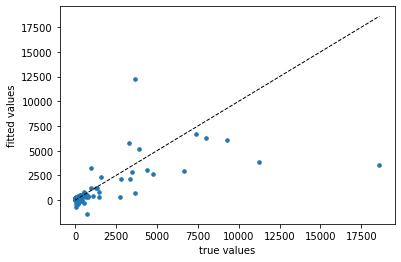

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     103.9
Date:                Thu, 19 Mar 2020   Prob (F-statistic):           7.03e-78
Time:                        18:51:31   Log-Likelihood:                -4725.3
No. Observations:                 577   AIC:                             9463.
Df Residuals:                     571   BIC:                             9489.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            94.2103     70.292      1.340

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df, df_y, pred_y = train_lr(0)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

### gopatriots

gopatriots
MSE for test data =  27588.58568971645
R2 score for test data =  0.6293383566038233


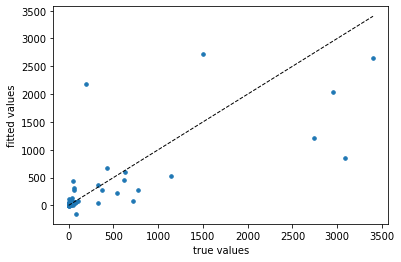

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     192.9
Date:                Thu, 19 Mar 2020   Prob (F-statistic):          7.06e-120
Time:                        18:51:35   Log-Likelihood:                -3749.1
No. Observations:                 574   AIC:                             7510.
Df Residuals:                     568   BIC:                             7536.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.0229     10.869      0.554

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df, df_y, pred_y = train_lr(1)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

### nfl

nfl
MSE for test data =  270401.91406034445
R2 score for test data =  0.5707688538937594


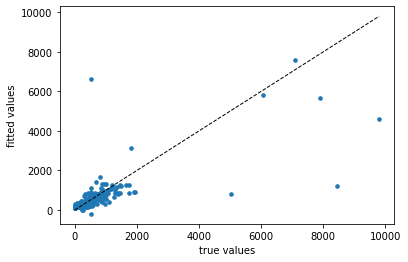

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     154.0
Date:                Thu, 19 Mar 2020   Prob (F-statistic):          7.45e-104
Time:                        18:52:07   Log-Likelihood:                -4488.6
No. Observations:                 585   AIC:                             8989.
Df Residuals:                     579   BIC:                             9015.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           123.7556     42.809      2.891

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df, df_y, pred_y = train_lr(2)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

### patriots

patriots
MSE for test data =  5189695.980567309
R2 score for test data =  0.6684079890987789


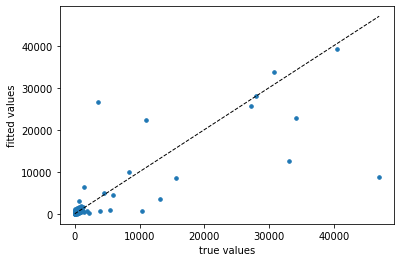

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     233.4
Date:                Thu, 19 Mar 2020   Prob (F-statistic):          3.35e-136
Time:                        18:53:12   Log-Likelihood:                -5352.8
No. Observations:                 585   AIC:                         1.072e+04
Df Residuals:                     579   BIC:                         1.074e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           181.2843    184.677      0.982

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df, df_y, pred_y = train_lr(3)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

### sb49

sb49
MSE for test data =  16107134.315916982
R2 score for test data =  0.804588854407114


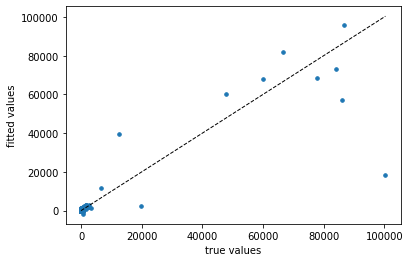

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     476.8
Date:                Thu, 19 Mar 2020   Prob (F-statistic):          1.45e-202
Time:                        18:55:04   Log-Likelihood:                -5684.1
No. Observations:                 585   AIC:                         1.138e+04
Df Residuals:                     579   BIC:                         1.141e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           171.9764    299.240      0.575

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df, df_y, pred_y = train_lr(4)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

### superbowl

superbowl
MSE for test data =  52573154.30093936
R2 score for test data =  0.7998348436989455


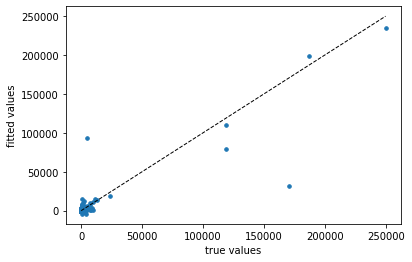

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     462.7
Date:                Thu, 19 Mar 2020   Prob (F-statistic):          1.51e-199
Time:                        18:57:40   Log-Likelihood:                -6030.1
No. Observations:                 585   AIC:                         1.207e+04
Df Residuals:                     579   BIC:                         1.210e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -150.5245    608.009     -0.248

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df, df_y, pred_y = train_lr(5)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

## Q4 Q5

In [0]:
def parse_dataset1(file):
    # extract raw features
    pst_tz = pytz.timezone('America/Los_Angeles')
    data_raw = []
    for line in open(path + file, 'r') :
        row_tmp = []
        a = json.loads(line)
        time = a['citation_date']
        retweet = a['metrics']['citations']['total']
        foll = a['author']['followers']             
        ment = len(a['tweet']['entities']['user_mentions'])
        medi = 0
        if 'entities' in a['tweet']:
            if 'media' in a['tweet']['entities']:
                if len(a['tweet']['entities']['media']) > 0:
                    if 'display_url' in a['tweet']['entities']['media'][0]:
                        medi += 1
                    if 'expanded_url' in a['tweet']['entities']['media'][0]:
                        medi += 1
                    if 'media_url_https' in a['tweet']['entities']['media'][0]:
                        medi += 1
                    elif 'media_url' in a['tweet']['entities']['media'][0]:
                        medi += 1
                if len(a['tweet']['entities']['urls']) > 0:
                    if 'display_url' in a['tweet']['entities']['urls'][0]:
                        medi += 1
                    if 'expanded_url' in a['tweet']['entities']['urls'][0]:
                        medi += 1
        if 'entended_entities' in a['tweet']:
            if 'media' in a['tweet']['entended_entities']:
                if len(a['tweet']['entended_entities']['media']) > 0:
                    if 'display_url' in a['tweet']['entended_entities']['media'][0]:
                        medi += 1
                    if 'expanded_url' in a['tweet']['entended_entities']['media'][0]:
                        medi += 1
                    if 'media_url_https' in a['tweet']['entended_entities']['media'][0]:
                        medi += 1
                    elif 'media_url' in a['tweet']['entended_entities']['media'][0]:
                        medi += 1
        hist_tw = a['tweet']['user']["statuses_count"]
        hist_yr = a['tweet']['user']['created_at'][-4:]
        acti = hist_tw/(2015-float(hist_yr)+1) 
        auth = a['author']['name']
        favo = a['tweet']['user']['favourites_count']
        titl = len(a['title'])
        
        # append to list
        row_tmp.append(time)
        row_tmp.append(retweet)
        row_tmp.append(foll)    
        row_tmp.append(ment) 
        row_tmp.append(medi) 
        row_tmp.append(acti)  
        row_tmp.append(auth)
        row_tmp.append(favo)
        row_tmp.append(titl)        
        data_raw.append(row_tmp)
    
    # sort according to time
    pddata_raw = pd.DataFrame(data_raw,columns=['time','retweets','followers','mentioned','media',\
                                                'active','author','favourites_count','title'])
    pddata_raw = pddata_raw.sort_values(by = 'time')
    pddata_raw = pddata_raw.reset_index(drop=True)
    pddata_raw['tweets'] = 1                   
#     print(pddata_raw)

    # reset time to hour index
    hour_accu = []
    hour_day = []
    for index, row in pddata_raw.iterrows():  
        p = datetime.datetime.fromtimestamp(row["time"], pst_tz)  
        hour_accu.append(((p.month-1)*31+p.day-14)*24+p.hour)
        hour_day.append(p.hour)    
    pddata_raw["time"] = hour_accu
    pddata_raw["hour of day"] = hour_day
    
    # create a new dataframe with desired form
    df = pd.DataFrame([],columns=['hour index','tweets','retweets','followers sum','followers max',\
                                  'mentioned','url_ratio','active','author','favourites_count','title'])
    df['hour index'] = range(pddata_raw.iloc[len(pddata_raw.index)-1,0]+1)
    df['tweets'] = pddata_raw.groupby("time")['tweets'].sum()
    df['retweets'] = pddata_raw.groupby("time")['retweets'].sum()
    df['followers sum'] = pddata_raw.groupby("time")['followers'].sum()
    df['followers max'] = pddata_raw.groupby("time")["followers"].max()
    df['mentioned'] = pddata_raw.groupby("time")['mentioned'].sum()
    df['url_ratio'] = pddata_raw.groupby("time")['media'].sum() / pddata_raw.groupby("time")['media'].count().astype("float")
    df['active'] = pddata_raw.groupby("time")['active'].mean()  
    df['author'] = pddata_raw.groupby("time")['author'].nunique() # count number of not-repeating authors    
    df['favourites_count'] = pddata_raw.groupby("time")['favourites_count'].sum()
    df['title'] = pddata_raw.groupby("time")['title'].mean()
            
    # reset index of df
    df = df.drop([0]).fillna(0).reset_index(drop=True)

    # assign number of tweets of the next hour to be the target value
    df_y = df.iloc[1:,1].reset_index(drop=True)
    df = df[:len(df_y)]
    
    return df.iloc[:,1:],df_y

In [0]:
def train_lr1(i):
    """
    This function gets data and train using a linear regression model
    """    
    df, df_y = parse_dataset1(files[i])

    reg = LinearRegression().fit(df, df_y)
    pred_y = reg.predict(df)
    MSE = mean_squared_error(df_y, pred_y)
    R2 = r2_score(df_y, pred_y)
    
    print(topics[i])
    print('MSE for test data = ',MSE)
    print('R2 score for test data = ',R2)   
    
    return df, df_y, pred_y

In [0]:
features = ['tweets', 'retweets', 'followers sum', 'followers max', 'mentioned', 'url_ratio', 'active', 'author', 'favourites_count', 'title']

def plot_feature_vs_pred(df,pred_y,features,top3):
    for i in top3:
        plt.figure()
        area = np.pi * (4)**2/4
        plt.scatter(df[features[i]], pred_y, s = area)
        plt.xlabel('feature: '+features[i])
        plt.ylabel('fitted values')
    plt.show()

### gohawks

gohawks
MSE for test data =  536339.8552752357
R2 score for test data =  0.6304423536400289


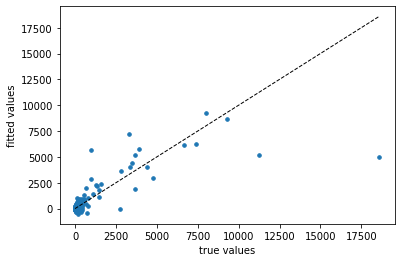

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     96.56
Date:                Thu, 19 Mar 2020   Prob (F-statistic):          1.99e-115
Time:                        19:21:19   Log-Likelihood:                -4624.8
No. Observations:                 577   AIC:                             9272.
Df Residuals:                     566   BIC:                             9319.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               65.1137    190.837  

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df, df_y, pred_y = train_lr1(0)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

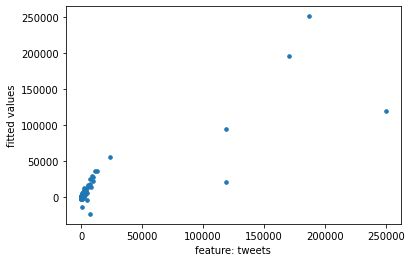

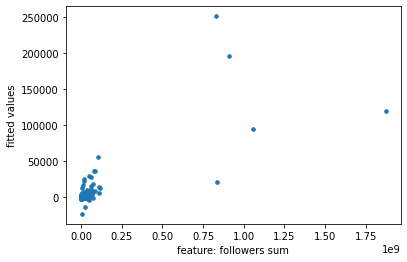

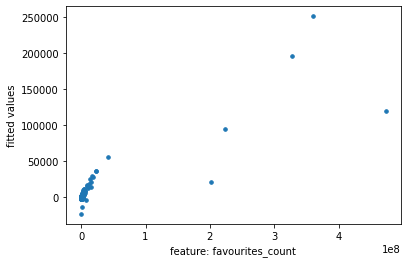

In [0]:
plot_feature_vs_pred(df,pred_y,features,[0,2,8])

### gopatriots

gopatriots
MSE for test data =  8459.428739863255
R2 score for test data =  0.8863448168682551


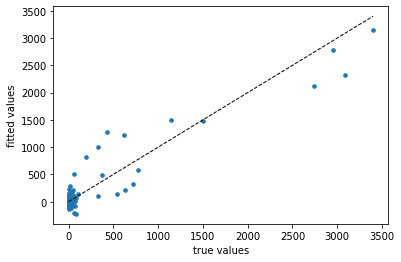

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     439.1
Date:                Thu, 19 Mar 2020   Prob (F-statistic):          2.36e-258
Time:                        19:43:30   Log-Likelihood:                -3409.8
No. Observations:                 574   AIC:                             6842.
Df Residuals:                     563   BIC:                             6890.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.3020      7.504  

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df, df_y, pred_y = train_lr1(1)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

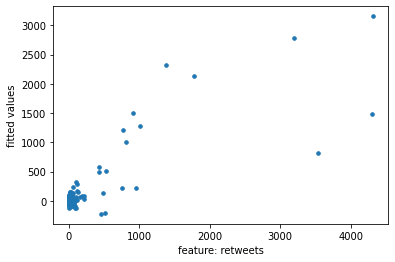

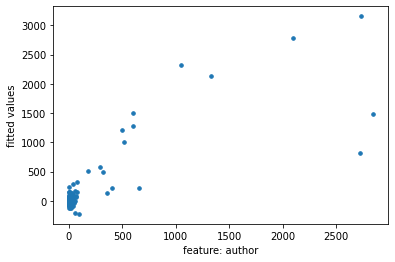

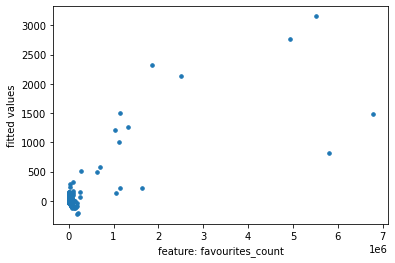

In [0]:
plot_feature_vs_pred(df,pred_y,features,[1,7,8])

### nfl

nfl
MSE for test data =  189254.8008673475
R2 score for test data =  0.6995803252181446


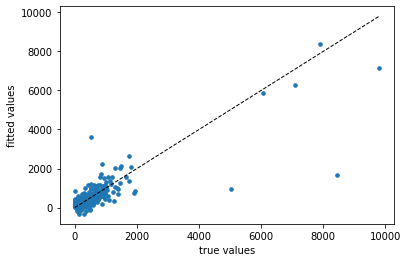

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     133.7
Date:                Thu, 19 Mar 2020   Prob (F-statistic):          9.04e-143
Time:                        19:48:35   Log-Likelihood:                -4384.2
No. Observations:                 585   AIC:                             8790.
Df Residuals:                     574   BIC:                             8838.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              287.1452    195.357  

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df, df_y, pred_y = train_lr1(2)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

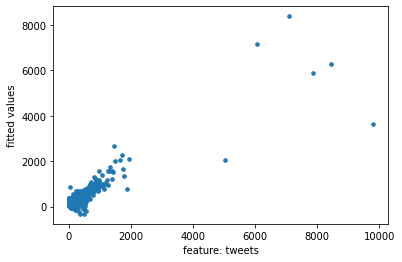

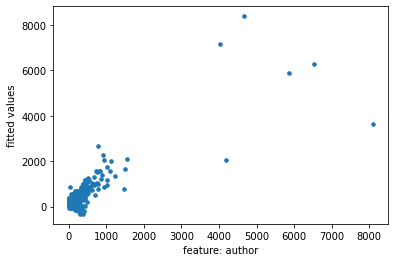

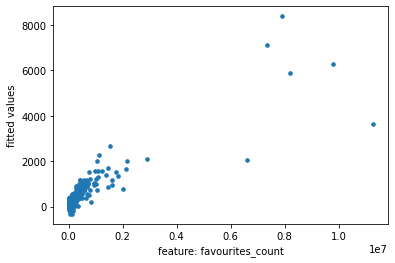

In [0]:
plot_feature_vs_pred(df,pred_y,features,[0,7,8])

### patriots

patriots
MSE for test data =  3701906.9318352095
R2 score for test data =  0.7634692343650118


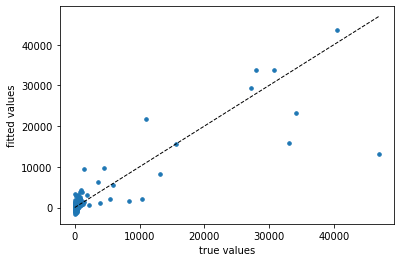

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     185.3
Date:                Thu, 19 Mar 2020   Prob (F-statistic):          2.02e-172
Time:                        19:50:45   Log-Likelihood:                -5254.0
No. Observations:                 585   AIC:                         1.053e+04
Df Residuals:                     574   BIC:                         1.058e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             5189.1889   1410.752  

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df, df_y, pred_y = train_lr1(3)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

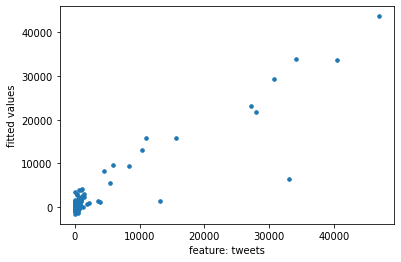

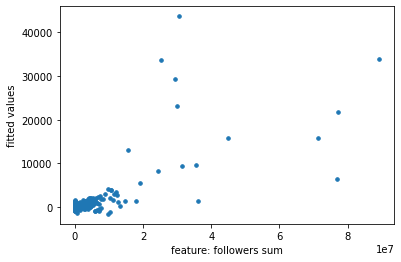

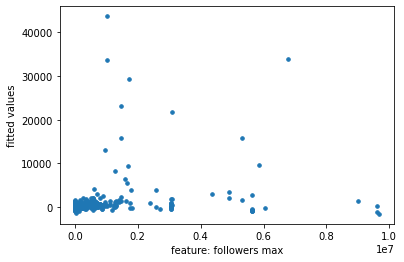

In [0]:
plot_feature_vs_pred(df,pred_y,features,[0,2,3])

### sb49

sb49
MSE for test data =  14222241.832739882
R2 score for test data =  0.8274562988719606


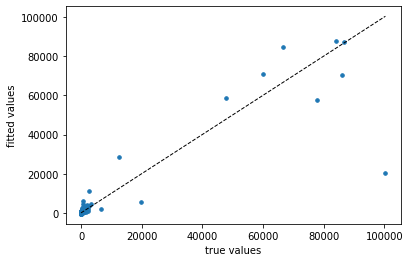

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     275.3
Date:                Thu, 19 Mar 2020   Prob (F-statistic):          1.34e-211
Time:                        19:56:10   Log-Likelihood:                -5647.6
No. Observations:                 585   AIC:                         1.132e+04
Df Residuals:                     574   BIC:                         1.137e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              251.8655    505.520  

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df, df_y, pred_y = train_lr1(4)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

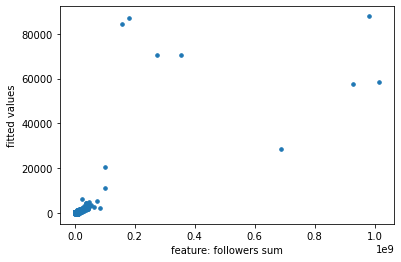

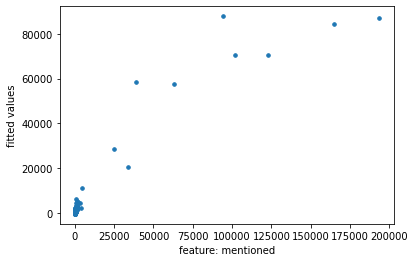

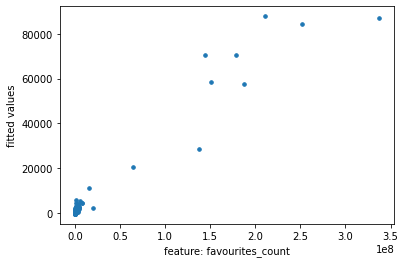

In [0]:
plot_feature_vs_pred(df,pred_y,features,[2,4,8])

### superbowl

superbowl
MSE for test data =  32004965.335808694
R2 score for test data =  0.8781454342233084


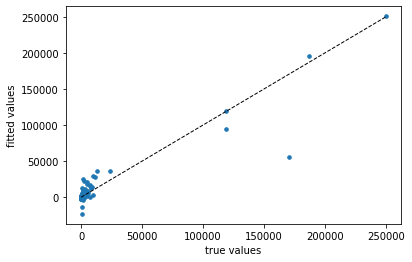

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     413.7
Date:                Thu, 19 Mar 2020   Prob (F-statistic):          7.55e-255
Time:                        20:00:29   Log-Likelihood:                -5884.9
No. Observations:                 585   AIC:                         1.179e+04
Df Residuals:                     574   BIC:                         1.184e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             5021.7282   3764.499  

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df, df_y, pred_y = train_lr1(5)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

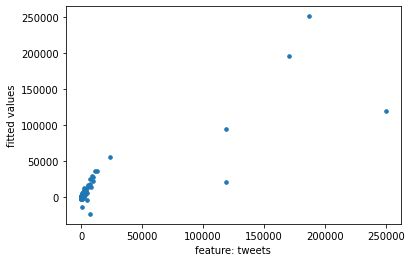

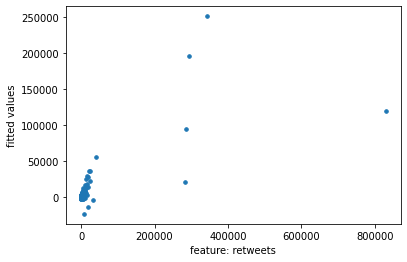

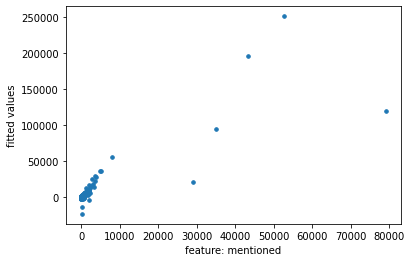

In [0]:
plot_feature_vs_pred(df,pred_y,features,[0,1,4])